<a href="https://colab.research.google.com/github/hemanths03/CS6910/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 8.4 MB/s 
     |████████████████████████████████| 144 kB 63.4 MB/s 
     |████████████████████████████████| 180 kB 58.8 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=5193799a7af57fc7bf50242cda8ed5a8c95502b6919f5840ed21c807c1d0a90d
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
import wandb
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import log_loss
from keras.datasets import fashion_mnist

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
labels = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
N , a , b = train_images.shape
#Dimesion of each Datapoint will be a*b
x = a*b
d = x
nl = len(labels)

4431872/4422102 [==============================] - 0s 0us/step


#Question 1


In [5]:
def show_images(train_images , train_labels , desc):
  m=0
  n=0
  k=0
  fig, axes = plt.subplots(2, 5, figsize=(12.5,6))
  for i in range(1000):
    if train_labels[i]==k:
      ax = axes[m,n]
      ax.imshow(train_images[i], cmap='gray')
      ax.set_title('Class='+str(train_labels[i])+', Label='+str(desc[train_labels[i]]))
      n=n+1
      k=k+1
      if(n==5):
        m=1
        n=0
    if k==10:
      break
  plt.tight_layout()
  plt.show()

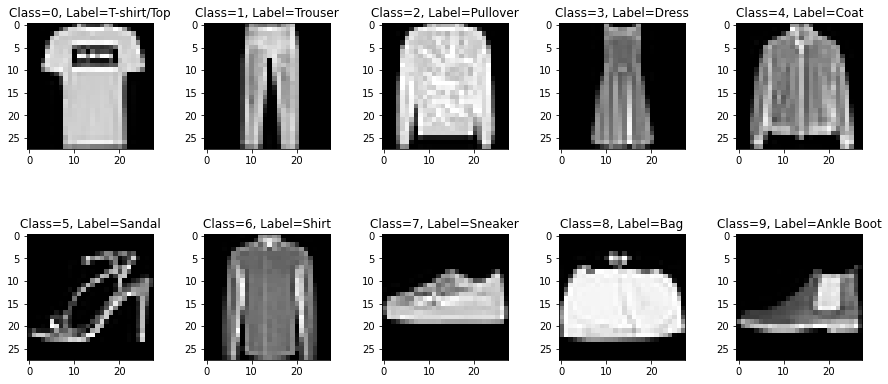

In [6]:
#Showing one image of each class (Question - 1)
show_images(train_images , train_labels,labels)

#Propecessing of data



In [7]:
#Flattening we are converting the 28*28 data point as 784*1 data point
flatted_train_images =  np.array([train_images[i].flatten() for i in range(len(train_images))])
#Same transition for testdata
flatted_test_images =  np.array([test_images[i].flatten() for i in range(len(test_images))])

In [8]:
#getting train data and validation data from training data
from sklearn.model_selection import train_test_split
train_x, valid_x, cat_train_y, cat_val_y = train_test_split(flatted_train_images, train_labels, test_size=0.1, stratify = train_labels ,random_state=42)

In [9]:
#One hot encoding of categorical labels 
def encode(data , nl):
  encode_data = np.array( [ [0]*nl for i in range(len(data))] )
  for i in range(len(data)):
    actual_label = data[i]
    encode_data[i][actual_label] = 1
  return encode_data

In [10]:
train_y = encode(cat_train_y , nl)
valid_y = encode(cat_val_y , nl)
test_y = encode(test_labels , nl)

In [11]:
#Normalizing the data
mean = np.mean(train_x , axis = 0)
train_x = (train_x - mean) /255
valid_x = (valid_x - mean)/255
test_x = (flatted_test_images - mean)/255

In [12]:
print(train_x.shape)
print(valid_x.shape)
print(test_x.shape)
print(train_y.shape)
print(valid_y.shape)
print(test_y.shape)

(54000, 784)
(6000, 784)
(10000, 784)
(54000, 10)
(6000, 10)
(10000, 10)


#Activation functions


In [13]:
def sigmoid(x):
    temp = []
    for i in range(len(x)):
      temp.append(1/(1 + np.exp(-(float(x[i])))))
    return np.array(temp)

def tanh(x):
    temp = []
    for i in range(len(x)):
      temp.append(np.tanh(x[i]))
    return np.array(temp)

def relu(x):
    temp = []
    for i in range(len(x)):
      temp.append(max(0,x[i]))
    return np.array(temp)

def softmax(x):
    temp = []
    sum = 0
    for i in range(len(x)):
      sum += np.exp(float(x[i]))
    for i in range(len(x)):
      temp.append( np.exp(float(x[i])) / sum)
    return np.array(temp)

def derivative_sigmoid(x):
    return x*(1 - x)

def derivative_tanh(x):
    return 1-np.square(x)

def derivative_relu(x):
    temp = []
    for i in range(len(x)):
      if x[i]>0:
        temp.append(1)
      else:
        temp.append(0)
    return np.array(temp)

#Network initialization

In [14]:
def initialize_zeros(dim,hl,ol):
  w = [np.array([])]
  b = [np.array([])]
  for i in range(len(hl)):
    b.append(np.zeros(hl[i]))
    if(i == 0):
      w.append(np.zeros((hl[i],d)))
    else:
      w.append(np.zeros((hl[i],hl[i - 1])))

  for i in range(len(ol)):
    b.append(np.zeros(ol[i]))
    w.append(np.zeros((ol[i],hl[-1])))
  return w , b

In [15]:
def initialize_network(dim, hl, ol, method):
  W = [np.array([])]
  b = [np.array([])]
  np.random.seed(2)
  #Random intialization
  if(method=='random'):
    for i in range(len(hl)):
      b.append(np.random.randn(hl[i]))
      if(i == 0):
        W.append(np.random.randn(hl[i],dim))
      else:
        W.append(np.random.randn(hl[i],hl[i - 1]))
    for i in range(len(ol)):
      b.append(np.random.randn(ol[i]))
      W.append(np.random.randn(ol[i],hl[-1]))
      
  #Xavier Initialization
  else:
    for i in range(len(hl)):
      b.append(np.random.randn(hl[i]))
      if(i == 0):
        W.append(np.random.randn(hl[i],dim ) * np.sqrt(1/dim))
      else:
        W.append(np.random.randn(hl[i],hl[i-1]) * np.sqrt(1/hl[i-1]))
    for i in range(len(ol)):
      b.append(np.random.randn(ol[i]))
      W.append(np.random.randn(ol[i],hl[-1]) * np.sqrt(1/hl[-1]))

  return W,b

#Forward Propagation

In [16]:
def forward_propagation(W,b,x,method):
    a = [[]]
    h = [[]]
    h[0] = x 
    num_layers = (len(W)-1)
    c = []
    d = []
    if method=='sigmoid':
        for i in range(1 , num_layers):
            c = np.dot( W[i], h[i-1] ) + b[i]
            a.append(c)
            d = sigmoid(c)
            h.append(d)

    elif method=='tanh':
        for i in range(1 , num_layers):
            c = np.dot( W[i], h[i-1] ) + b[i]
            a.append(c)
            d = tanh(c)
            h.append(d)

    elif method=='relu':
        for i in range(1 , num_layers):
            c = np.dot( W[i], h[i-1] ) + b[i]
            a.append(c)
            d = relu(c)
            h.append(d)

    c = np.dot( W[num_layers], h[num_layers-1] ) + b[num_layers]
    a.append(c)
    d = softmax(c)
    h.append(d)

    return a,h

#Backward Propagation

In [17]:
def back_prop(W,h,x,y,y_pred,act_fun,loss_fun):
  del_W,del_b=[[]],[[]]

  #Computing output grad wrt Cross Entropy Loss function
  if loss_fun == "cross_entropy" :
    del_a = (y_pred - y)
    
  #Computing output grad wrt Squared Error Loss function
  else:
    y_label = y_pred[np.argmax(y)]
    del_a = 2 * (y_label - 1) * y_label * ( y - y_pred )

  for i in range(len(W)-1, 0, -1):

    #computing gradients wrt parameters W,b
    dW = np.array(np.dot(np.matrix(del_a).T , np.matrix(h[i-1])))
    db = np.array( del_a )

    #computing gradients wrt below layer activation function
    dh = np.dot( np.transpose(W[i]), del_a )

    #computing gradients wrt below layer pre-activation function
    if act_fun == "sigmoid":
      del_a = dh * derivative_sigmoid( h[i - 1] )
    
    elif act_fun == "tanh":
      del_a = dh * derivative_tanh( h[i - 1] )
    
    elif act_fun == "relu":
      del_a = dh * derivative_relu( h[i - 1] )

    del_W.insert(1, dW)
    del_b.insert(1, db)

  return del_W, del_b

#Stochastic Gradient Descent optimizer

In [18]:
def stochastic_gradient_descent(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha,batch):
  #Initializing the weights and biases based on given strategy
  W,b = initialize_network(d, hl, ol, strat)
  dw , db = initialize_zeros(784,hl,ol)

  seen = 0
  for e in range(epochs):
    
    for it, (x, y) in enumerate(zip(train_x, train_y)):
      seen += 1
      a,h = forward_propagation(W, b, x, act_fun)
      y_pred=h[len(h)-1]
      tdw,tdb=back_prop(W, h, x, y, y_pred, act_fun, loss_fun)

      for i in range(len(tdw)):
        dw[i] += tdw[i]
        db[i] += tdb[i]

      if(seen==batch or it==len(train_x)-1):
        seen = 0

        for i, (weight, deriv) in enumerate(zip(W, dw)):
          W[i] = weight - eta * np.array(deriv)

        for i, (bias, deriv) in enumerate(zip(b, db)):
          b[i] = bias - eta * np.array(deriv)
        
        dw , db = initialize_zeros(784,hl,ol)

    val_acc, val_loss = get_predictions_accuracy(W, b, valid_x, valid_y, act_fun, loss_fun)
    train_acc, train_loss = get_predictions_accuracy(W, b, train_x, train_y, act_fun, loss_fun)
    test_acc, test_loss = get_predictions_accuracy(W, b, test_x, test_y, act_fun, loss_fun)
    print(e+1,"accuracy", train_acc , val_acc, test_acc)
    
    wandb.log({
        "Epoch": e+1,
        "Train Loss": train_loss,
        "Train Acc": train_acc,
        "Valid Loss": val_loss,
        "Valid Acc": val_acc})
  return val_acc

#Momentum Based Gradient Descent 

In [19]:
def momentum_gradient_descent(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha,batch):
  W,b=initialize_network(d, hl, ol, strat)
  dw , db = initialize_zeros(784,hl,ol)
  prev_w , prev_b = initialize_zeros(784,hl,ol)
  gamma=0.9
  seen=0

  for e in range(epochs):
    #dw , db = initialize_zeros(784,hl,ol)
    for it, (x, y) in enumerate(zip(train_x, train_y)):
      seen+=1
      a,h = forward_propagation(W, b, x, act_fun)
      y_pred=h[len(h)-1]
      
      tdw,tdb=back_prop(W, h, x, y, y_pred, act_fun, loss_fun)
  
      for i in range(len(tdw)):
        dw[i] += tdw[i]
        db[i] += tdb[i]
    
      if(seen==batch or it==len(train_x)-1):
        seen=0
        for i, (weight, deriv) in enumerate(zip(W, dw)):
          W[i] = weight - eta * np.array(deriv) - gamma*prev_w[i]
          prev_w[i] = eta * np.array(deriv) + gamma*prev_w[i]

        for i, (bias, deriv) in enumerate(zip(b, db)):
          b[i] = bias - eta * np.array(deriv) - gamma*prev_b[i]
          prev_b[i] = eta * np.array(deriv) + gamma*prev_b[i]

        dw , db = initialize_zeros(784,hl,ol)

    val_acc, val_loss = get_predictions_accuracy(W, b, valid_x, valid_y, act_fun, loss_fun)
    train_acc, train_loss = get_predictions_accuracy(W, b, train_x, train_y, act_fun, loss_fun)
    test_acc, test_loss = get_predictions_accuracy(W, b, test_x, test_y, act_fun, loss_fun)
    print(e+1,"accuracy", train_acc , val_acc, test_acc)

    wandb.log({
        "Epoch": e+1,
        "Train Loss": train_loss,
        "Train Acc": train_acc,
        "Valid Loss": val_loss,
        "Valid Acc": val_acc})
  return val_acc

#Nesterov Accelerated Gradient Descent

In [20]:
def nesterov_gradient_descent(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha,batch):
  W,b=initialize_network(d, hl, ol, strat)

  gamma=0.9
  seen=0

  
  prev_w , prev_b = initialize_zeros(784,hl,ol)
  v_w , v_b =initialize_zeros(784,hl,ol)

  dw , db = initialize_zeros(784,hl,ol)
  tw , tb = initialize_zeros(784,hl,ol)

  for e in range(epochs):

    for i in range(len(W)):
      v_w[i] = gamma*prev_w[i]
      v_b[i] = gamma*prev_b[i]
    

    for i in range(len(W)):
      tw[i] = W[i] - v_w[i]
      tb[i] = b[i] - v_b[i]
  
    for it, (x, y) in enumerate(zip(train_x, train_y)):
      seen+=1

      a,h = forward_propagation(tw, tb, x, act_fun)
      y_pred=h[len(h)-1]
      
      tdw,tdb=back_prop(tw, h, x, y, y_pred, act_fun, loss_fun)
      
      for i in range(len(tdw)):
        dw[i] += tdw[i]
        db[i] += tdb[i]

      if seen==batch or it == len(train_x)-1:
        seen=0
        for i, (weight, deriv) in enumerate(zip(W, dw)):
          v_w[i] = gamma*prev_w[i] + eta*np.array(deriv)
          W[i] = weight - v_w[i]
          tw[i] = W[i]
          prev_w = v_w

        for i, (bias, deriv) in enumerate(zip(b, db)):
          v_b[i] = gamma*prev_b[i] + eta*np.array(deriv)
          b[i] = bias - v_b[i]
          tb[i] = b[i]
          prev_b = v_b
        
        dw , db = initialize_zeros(784,hl,ol)

    val_acc, val_loss = get_predictions_accuracy(W, b, valid_x, valid_y, act_fun, loss_fun)
    train_acc, train_loss = get_predictions_accuracy(W, b, train_x, train_y, act_fun, loss_fun)
    test_acc, test_loss = get_predictions_accuracy(W, b, test_x, test_y, act_fun, loss_fun)
    print(e+1,"accuracy", train_acc , val_acc, test_acc)

    wandb.log({
        "Epoch": e+1,
        "Train Loss": train_loss,
        "Train Acc": train_acc,
        "Valid Loss": val_loss,
        "Valid Acc": val_acc})
  return val_acc

#RMS_Prop Optimizer

In [21]:
def rmsprop(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha,batch):
  W,b=initialize_network(d, hl, ol, strat)
  seen=0
  
  prev_w , prev_b = initialize_zeros(784,hl,ol)
  dw , db = initialize_zeros(784,hl,ol)
  eps , beta = 1e-8 , 0.9

  for e in range(epochs):
  
    for it, (x, y) in enumerate(zip(train_x, train_y)):
      seen+=1
      a,h = forward_propagation(W, b, x, act_fun)
      y_pred=h[len(h)-1]
      
      tdw,tdb=back_prop(W, h, x, y, y_pred, act_fun, loss_fun)
      
      for i in range(len(tdw)):
        dw[i] += tdw[i]
        db[i] += tdb[i]

      if seen==batch or it == len(train_x)-1:

        seen=0

        for i in range(len(W)):
          prev_w[i] = beta*prev_w[i] + (1-beta)*(dw[i]**2)
          prev_b[i] = beta*prev_b[i] + (1-beta)*(db[i]**2)

        for i, (weight, deriv) in enumerate(zip(W, dw)):
          W[i] = weight - (eta / np.sqrt(prev_w[i] + eps)) * np.array(deriv)

        for i, (bias, deriv) in enumerate(zip(b, db)):
          b[i] = bias - (eta / np.sqrt(prev_b[i] + eps)) * np.array(deriv)
        
        dw , db = initialize_zeros(784,hl,ol)

    val_acc, val_loss = get_predictions_accuracy(W, b, valid_x, valid_y, act_fun, loss_fun)
    train_acc, train_loss = get_predictions_accuracy(W, b, train_x, train_y, act_fun, loss_fun)
    test_acc, test_loss = get_predictions_accuracy(W, b, test_x, test_y, act_fun, loss_fun)
    print(e+1,"accuracy", train_acc , val_acc, test_acc)

    wandb.log({
        "Epoch": e+1,
        "Train Loss": train_loss,
        "Train Acc": train_acc,
        "Valid Loss": val_loss,
        "Valid Acc": val_acc})
  return val_acc

#Adam Optimizer

In [22]:
def adaptive_moments(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha,batch):
  W,b=initialize_network(d, hl, ol, strat)
  seen=0
  c=0
  v_w , v_b = initialize_zeros(784,hl,ol)
  dw , db = initialize_zeros(784,hl,ol)
  m_w , m_b = initialize_zeros(784,hl,ol)
  eps , beta1 , beta2 = 1e-8 , 0.9 , 0.99

  m_w_hat , m_b_hat = initialize_zeros(784,hl,ol)
  v_w_hat , v_b_hat = initialize_zeros(784,hl,ol)

  for e in range(epochs):
  
    for it, (x, y) in enumerate(zip(train_x, train_y)):
      seen+=1
      a,h = forward_propagation(W, b, x, act_fun)
      y_pred=h[len(h)-1]
      
      tdw,tdb=back_prop(W, h, x, y, y_pred, act_fun, loss_fun)
      
      for i in range(len(tdw)):
        dw[i] += tdw[i]
        db[i] += tdb[i]

      if seen==batch or it == len(train_x)-1:

        seen=0
        c+=1
        for i in range(len(W)):
          m_w[i] = beta1 * m_w[i] + (1-beta1) * dw[i]
          m_b[i] = beta1 * m_b[i] + (1-beta1) * db[i]

          v_w[i] = beta2 * v_w[i] + (1-beta2) * (dw[i]**2)
          v_b[i] = beta2 * v_b[i] + (1-beta2) * (db[i]**2)

        for i in range(len(W)):
          m_w_hat[i] = m_w[i] / (1 - np.power(beta1,c))
          m_b_hat[i] = m_b[i] / (1 - np.power(beta1,c))

          v_w_hat[i] = v_w[i] / (1 - np.power(beta2,c))
          v_b_hat[i] = v_b[i] / (1 - np.power(beta2,c))

        for i, (weight, deriv) in enumerate(zip(W, dw)):
          W[i] = weight - (eta / np.sqrt(v_w_hat[i] + eps)) * m_w_hat[i]

        for i, (bias, deriv) in enumerate(zip(b, db)):
          b[i] = bias - (eta / np.sqrt(v_b_hat[i] + eps)) * m_b_hat[i]
        
        dw , db = initialize_zeros(784,hl,ol)

    val_acc, val_loss = get_predictions_accuracy(W, b, valid_x, valid_y, act_fun, loss_fun)
    train_acc, train_loss = get_predictions_accuracy(W, b, train_x, train_y, act_fun, loss_fun)
    test_acc, test_loss = get_predictions_accuracy(W, b, test_x, test_y, act_fun, loss_fun)
    print(e+1,"accuracy", train_acc , val_acc, test_acc)

    wandb.log({
        "Epoch": e+1,
        "Train Loss": train_loss,
        "Train Acc": train_acc,
        "Valid Loss": val_loss,
        "Valid Acc": val_acc})
  return val_acc

#Nadam Optimizer

In [23]:
def nadam(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha,batch):
  W,b=initialize_network(d, hl, ol, strat)
  seen=0
  c=0
  v_w , v_b = initialize_zeros(784,hl,ol)
  dw , db = initialize_zeros(784,hl,ol)
  m_w , m_b = initialize_zeros(784,hl,ol)
  eps , beta1 , beta2 = 1e-8 , 0.9 , 0.99

  m_w_hat , m_b_hat = initialize_zeros(784,hl,ol)
  v_w_hat , v_b_hat = initialize_zeros(784,hl,ol)

  for e in range(epochs):
  
    for it, (x, y) in enumerate(zip(train_x, train_y)):
      seen+=1
      a,h = forward_propagation(W, b, x, act_fun)
      y_pred=h[len(h)-1]
      
      tdw,tdb=back_prop(W, h, x, y, y_pred, act_fun, loss_fun)
      
      for i in range(len(tdw)):
        dw[i] += tdw[i]
        db[i] += tdb[i]

      if seen==batch or it == len(train_x)-1:

        seen=0
        c+=1
        for i in range(len(W)):
          m_w[i] = beta1 * m_w[i] + (1-beta1) * dw[i]
          m_b[i] = beta1 * m_b[i] + (1-beta1) * db[i]

          v_w[i] = beta2 * v_w[i] + (1-beta2) * (dw[i]**2)
          v_b[i] = beta2 * v_b[i] + (1-beta2) * (db[i]**2)

        for i in range(len(W)):
          m_w_hat[i] = ( (beta1 * m_w[i]) + ( (1 - beta1) * dw[i] ) )/ (1 - np.power(beta1,c))
          m_b_hat[i] = ( (beta1 * m_b[i]) + ( (1 - beta1) * db[i] ) )/ (1 - np.power(beta1,c))

          v_w_hat[i] = v_w[i] / (1 - np.power(beta2,c))
          v_b_hat[i] = v_b[i] / (1 - np.power(beta2,c))

        for i, (weight, deriv) in enumerate(zip(W, dw)):
          W[i] = weight - (eta / np.sqrt(v_w_hat[i] + eps)) * m_w_hat[i]

        for i, (bias, deriv) in enumerate(zip(b, db)):
          b[i] = bias - (eta / np.sqrt(v_b_hat[i] + eps)) * m_b_hat[i]
        
        dw , db = initialize_zeros(784,hl,ol)

    val_acc, val_loss = get_predictions_accuracy(W, b, valid_x, valid_y, act_fun, loss_fun)
    train_acc, train_loss = get_predictions_accuracy(W, b, train_x, train_y, act_fun, loss_fun)
    test_acc, test_loss = get_predictions_accuracy(W, b, test_x, test_y, act_fun, loss_fun)
    print(e+1,"accuracy", train_acc , val_acc, test_acc)
    
    wandb.log({
        "Epoch": e+1,
        "Train Loss": train_loss,
        "Train Acc": train_acc,
        "Valid Loss": val_loss,
        "Valid Acc": val_acc})
  return val_acc

#Predictions and accuracy function

In [24]:
def get_predictions_accuracy(W, b, X, y, method, loss_fun):
  sum,loss=0,0
  for dp in range(len(X)):
    a = []
    h = []
    h = X[dp] 
    num_layers = (len(W)-1)
    if method=='sigmoid':
      for i in range(1 , num_layers):
        a = np.dot( W[i], h ) + b[i]
        h = sigmoid(a)

    elif method=='tanh':
      for i in range(1 , num_layers):
        a = np.dot( W[i], h ) + b[i]
        h = tanh(a)

    elif method=='relu':
      for i in range(1 , num_layers):
        a = np.dot( W[i], h ) + b[i]
        h = relu(a)

    a = np.dot( W[num_layers], h ) + b[num_layers]
    y_pred = softmax(a)

    ytrue = y[dp]
    if(ytrue[np.argmax(y_pred)]==1):
      sum=sum+1
    
    loss += -np.sum(ytrue*np.log(y_pred))

  acc=sum/len(X)
  loss=loss/len(X)
  return acc,loss


In [ ]:
'''hidden_layer_size = 64
hidden_layers = 3
hl = [hidden_layer_size]*hidden_layers
ol = [len(train_y[0])]
n_hl = len(hl)
act_fun ='tanh'
loss_fun='cross-entropy'
eta=0.001
alpha=0
strat='xavier'
epochs=5
nadam(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha) '''

"hidden_layer_size = 64\nhidden_layers = 3\nhl = [hidden_layer_size]*hidden_layers\nol = [len(train_y[0])]\nn_hl = len(hl)\nact_fun ='tanh'\nloss_fun='cross-entropy'\neta=0.001\nalpha=0\nstrat='xavier'\nepochs=5\nnadam(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha) "

#Sweep Configuration

In [25]:
sweep_config_temp={
  "name": "mgd_sweep",
  "method": "bayes",
  "early_terminate":{
      "type": "hyperband",
      "min_iter": 2
  },
  "metric": {
      "name": "Valid Acc",
      "goal": "maximize"   
    },
  "parameters": {
        "epochs": {
            "values": [5]
        },
        "hidden_layers":{
            "values":[3,4,5]
        },
        "hidden_layer_size":{
            "values":[64,128]  
        },
        "eta":{
            "values":[0.01]
        },
        "optimizer":{
            "values":['mgd']
        },
        "batch_size": {
            "values": [32,64]
        },
        "alpha":{
            "values":[0]
        },
        "strat":{
            "values":['random','xavier']
        },
        "act_fun":{
            "values":['tanh','relu','sigmoid']
        }
    }
}

#Training function to call specified Optimizer

In [26]:
def train():
  run=wandb.init()
  config = wandb.config
  loss_fun='cross-entropy'
  hl = [config.hidden_layer_size]*config.hidden_layers
  ol = [len(train_y[0])]

  name = "hl_" + str(config.hidden_layers) + "_bs_" + str(config.batch_size) + "_ac_" + config.act_fun
  run.name = name

  alpha=0

  if config.optimizer == 'sgd':
    val_acc=stochastic_gradient_descent(train_x,train_y,valid_x,valid_y,d,hl,ol,config.act_fun,loss_fun,config.epochs,config.eta,config.strat,alpha,config.batch_size)

  if config.optimizer == 'rmsprop':
    val_acc=rmsprop(train_x,train_y,valid_x,valid_y,d,hl,ol,config.act_fun,loss_fun,config.epochs,config.eta,config.strat,alpha,config.batch_size)

  if config.optimizer == 'mgd':
    val_acc=momentum_gradient_descent(train_x,train_y,valid_x,valid_y,d,hl,ol,config.act_fun,loss_fun,config.epochs,config.eta,config.strat,alpha,config.batch_size)
  
  if config.optimizer == 'nag':
    val_acc=nesterov_gradient_descent(train_x,train_y,valid_x,valid_y,d,hl,ol,config.act_fun,loss_fun,config.epochs,config.eta,config.strat,alpha,config.batch_size)
  
  if config.optimizer == 'adam':
    val_acc=adaptive_moments(train_x,train_y,valid_x,valid_y,d,hl,ol,config.act_fun,loss_fun,config.epochs,config.eta,config.strat,alpha,config.batch_size)

  if config.optimizer == 'nadam':
    val_acc=nadam(train_x,train_y,valid_x,valid_y,d,hl,ol,config.act_fun,loss_fun,config.epochs,config.eta,config.strat,alpha,config.batch_size)

#Training

In [ ]:
sweep_id = wandb.sweep(sweep_config_temp, entity="cs21m027_cs21m011", project="DL_ASG_1_final")

Create sweep with ID: mj0chv68
Sweep URL: https://wandb.ai/cs21m027_cs21m011/DL_ASG_1_final/sweeps/mj0chv68


In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: 3mff1pde with config:
wandb: 	act_fun: relu
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	eta: 0.0001
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	strat: xavier


1 accuracy 0.8314814814814815 0.8351666666666666 0.8204
2 accuracy 0.858574074074074 0.8641666666666666 0.842
3 accuracy 0.8697037037037038 0.8736666666666667 0.8523
4 accuracy 0.8773703703703704 0.8773333333333333 0.8579
5 accuracy 0.8837962962962963 0.882 0.8622


Epoch,▁▃▅▆█
Train Acc,▁▅▆▇█
Train Loss,█▄▃▂▁
Valid Acc,▁▅▇▇█
Valid Loss,█▄▂▁▁
Epoch,5
Train Acc,0.8838
Train Loss,0.39838
Valid Acc,0.882
Valid Loss,0.39949


wandb: Agent Starting Run: 4nd7vo1d with config:
wandb: 	act_fun: relu
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	eta: 0.0001
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	strat: random


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
wandb: Ctrl + C detected. Stopping sweep.
